# Imports

In [4]:
import tensorflow
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import DirectoryIterator
from sklearn.model_selection import train_test_split
import os

# Get data

## without augmentation

In [9]:
def get_data(val_split = False, val_size = 0.3):
    '''Cette fonction parcourt le dossier contenant les images de départ et les renvoie,
    en uniformisant les tailles, sous forme de nd-arrays NumPy. La fonction exécute
    aussi un train_test_split qui distingue un dataset d'entraînement (70% des images)
    et un dataset de test (30% des images). '''
    path = '../catchafish/data'
    batch_size = 100000

    dir_iterator = DirectoryIterator(directory = path,
                                     image_data_generator = None,
                                     target_size = (128, 128),
                                     batch_size = batch_size,
                                     shuffle = False,
                                     dtype = int)

    X = dir_iterator[0][0]
    y = dir_iterator.labels

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 1)

    if val_split:
        X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = val_size)
        return X_train, X_val, X_test, y_train, y_val, y_test
    else:
        return X_train, X_test, y_train, y_test

In [10]:
X_train, X_test, y_train, y_test = get_data()

Found 1305 images belonging to 11 classes.


/home/lilahammer/.pyenv/versions/3.7.7/envs/lewagon/lib/python3.7/site-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


## with augmentation

In [31]:
zca_whitening = True
path = '../catchafish/test_data'
batch_size = 1500
dir_iterator = DirectoryIterator(directory = path, 
                                 image_data_generator = None,
                                 target_size = (128, 128),
                                 batch_size = batch_size,
                                 shuffle = False,
                                 dtype = int)
X = dir_iterator[0][0] / 255
y = dir_iterator.labels
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 1)
image_data_generator = ImageDataGenerator(zca_whitening = zca_whitening, 
                                          rotation_range = 5,
                                          width_shift_range = 0.3, 
                                          height_shift_range = 0.3, 
                                          shear_range = 0.3, 
                                          zoom_range = 0.3, 
                                          horizontal_flip = True, 
                                          fill_mode = 'nearest')
if zca_whitening:
    image_data_generator.fit(X_train)
extended_output = []
for images in image_data_generator.flow(X_train, y_train, batch_size = batch_size):
    extended_output.append(images)
    if len(extended_output) == 5:
        break
X_train = extended_output[0][0]
y_train = extended_output[0][1]
for data_tuple in extended_output[1:]:
    X_train = np.concatenate((X_train, data_tuple[0]), axis = 0)
    y_train = np.concatenate((y_train, data_tuple[1]), axis = 0)

Found 1305 images belonging to 11 classes.


NameError: name 'zca_whitening' is not defined

## y to categorical

In [11]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, 11)
y_test = to_categorical(y_test, 11)

## def model

In [23]:
from __future__ import print_function
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
import os

def build_model():
    model = Sequential()
    model.add(Conv2D(32, (5, 5), padding='same', input_shape=(128, 128, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    
    model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(3, 3)))
    model.add(Dropout(0.2))
    
    model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(3, 3)))
    model.add(Dropout(0.2))
    
    model.add(Flatten())
    model.add(Dense(40, activation='relu'))
    model.add(Dense(11, activation='softmax'))
    
    return model

In [24]:
def compile_model(model):
    opt = tensorflow.keras.optimizers.Adam(learning_rate=1e-3)
    model.compile(loss='categorical_crossentropy',
                  optimizer=opt,
                  metrics=['accuracy'])
    return model

model = build_model()
model = compile_model(model)
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 128, 128, 32)      2432      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 64, 64, 32)        9248      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 21, 21, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 21, 21, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 21, 21, 64)       

In [25]:
from tensorflow.keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_loss', mode='min', patience=5, verbose=1, restore_best_weights=True, min_delta=1e-2)
#tensorflow.config.experimental_run_functions_eagerly(True)

# training model

In [26]:
history = model.fit(X_train, y_train, validation_split=0.3, callbacks=[es], epochs=100, batch_size=32)

Epoch 1/100
20/20 [==============================] - 22s 1s/step - loss: 30.9094 - accuracy: 0.0908 - val_loss: 2.5068 - val_accuracy: 0.1387
Epoch 2/100
20/20 [==============================] - 23s 1s/step - loss: 2.6838 - accuracy: 0.1017 - val_loss: 2.3643 - val_accuracy: 0.1277
Epoch 3/100
20/20 [==============================] - 24s 1s/step - loss: 2.4224 - accuracy: 0.1174 - val_loss: 2.3409 - val_accuracy: 0.1569
Epoch 4/100
20/20 [==============================] - 24s 1s/step - loss: 2.3338 - accuracy: 0.1721 - val_loss: 2.3314 - val_accuracy: 0.1606
Epoch 5/100
20/20 [==============================] - 22s 1s/step - loss: 2.3039 - accuracy: 0.1831 - val_loss: 2.2645 - val_accuracy: 0.1971
Epoch 6/100
20/20 [==============================] - 21s 1s/step - loss: 2.2141 - accuracy: 0.2144 - val_loss: 2.2479 - val_accuracy: 0.2044
Epoch 7/100
20/20 [==============================] - 25s 1s/step - loss: 2.1875 - accuracy: 0.2222 - val_loss: 2.1791 - val_accuracy: 0.2263
Epoch 8/100


In [27]:
def plot_history(history, title='', axs=None, exp_name=""):
    if axs is not None:
        ax1, ax2 = axs
    else:
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    if len(exp_name) > 0 and exp_name[0] != '_':
        exp_name = '_' + exp_name
    ax1.plot(history.history['loss'], label='train' + exp_name)
    ax1.plot(history.history['val_loss'], label='val' + exp_name)
    #ax1.set_ylim(0., 2.2)
    ax1.set_title('BCE loss')
    ax1.legend()

    ax2.plot(history.history['accuracy'], label='train accuracy'  + exp_name)
    ax2.plot(history.history['val_accuracy'], label='val accuracy'  + exp_name)
    #ax2.set_ylim(0.25, 1.)
    ax2.set_title('Accuracy')
    ax2.legend()
    return (ax1, ax2)

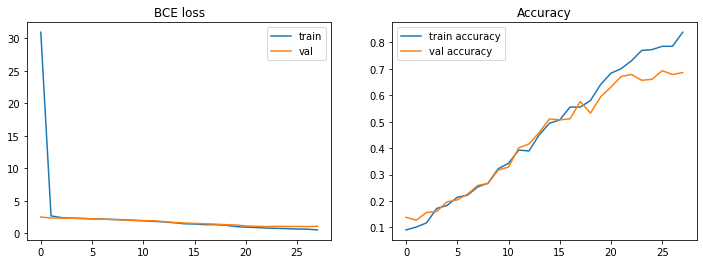

In [28]:
plot_history(history)
plt.show()

# evaluating model

In [29]:
model.evaluate(X_test, y_test, verbose=0)

[1.1434848308563232, 0.6352040767669678]